Web Scraping with Requests and BeautifulSoup
==
In this section, we use Requests to download a Wikipedia page about Natural Language Processing, and BeautifulSoup to extract the raw text from <p> paragraph tags.

This demonstrates how to:

1. Send an HTTP request to a webpage

2. Parse the HTML content

3. Extract specific elements such as text paragraphs

The extracted text will serve as our input for later NLP tasks.

In [ ]:
import requests
from bs4 import BeautifulSoup

# Target URL (Wikipedia page on NLP)
url = "https://en.wikipedia.org/wiki/Natural_language_processing"

# Send HTTP request
response = requests.get(url)

# Parse the HTML content using BeautifulSoup
soup = BeautifulSoup(response.content, "html.parser")

# Extract the first few paragraph elements
paragraphs = soup.find_all("p") #p is the tag for paragraphs in HTML

# Display the first 3 paragraphs
for i, p in enumerate(paragraphs[:3]):
    print(f"Paragraph {i+1}:\n", p.get_text(strip=True), "\n")



Paragraph 1:
 Natural language processing(NLP) is a subfield ofcomputer scienceand especiallyartificial intelligence. It is primarily concerned with providing computers with the ability to process data encoded innatural languageand is thus closely related toinformation retrieval,knowledge representationandcomputational linguistics, a subfield oflinguistics. 

Paragraph 2:
 Major tasks in natural language processing arespeech recognition,text classification,natural language understanding, andnatural language generation. 

Paragraph 3:
 Natural language processing has its roots in the 1950s.[1]Already in 1950,Alan Turingpublished an article titled "Computing Machinery and Intelligence" which proposed what is now called theTuring testas a criterion of intelligence, though at the time that was not articulated as a problem separate from artificial intelligence. The proposed test includes a task that involves the automated interpretation and generation of natural language. 



Text Cleaning using SpaCy and NLTK
==
Now that we have raw HTML text, we clean it up and prepare it for NLP:

1. Convert text to lowercase

2. Remove stopwords (common words like “and”, “the”)

3. Lemmatize the tokens (reduce words to their base form like “running” → “run”)

We use:

1. SpaCy for tokenization and lemmatization

2. NLTK for stopwords in English

This step transforms messy text into meaningful tokens suitable for further processing.

In [2]:
import spacy
import nltk
from nltk.corpus import stopwords

# Load the English SpaCy model
nlp = spacy.load("en_core_web_sm")

# Get raw text from the first paragraph
text = paragraphs[0].get_text()

# Process the text with SpaCy
doc = nlp(text.lower())

# Extract clean tokens: lemmatized, alphabetic, and not stopwords
clean_tokens = [
    token.lemma_ for token in doc
    if token.is_alpha and token.text not in stopwords.words("english")
]

# Show a preview of the result
print("Cleaned tokens:", clean_tokens[:20])



Cleaned tokens: ['natural', 'language', 'processing', 'nlp', 'subfield', 'computer', 'science', 'especially', 'artificial', 'intelligence', 'primarily', 'concerned', 'provide', 'computer', 'ability', 'process', 'datum', 'encode', 'natural', 'language']


Spelling Correction with SymSpell
==
In real-world data, typos and spelling errors are common. SymSpell uses a precompiled dictionary with word frequencies and hash-based lookups to suggest corrections efficiently.

Here we:

1. Load a frequency dictionary

2. Simulate a typo ("langauge")

3. Retrieve correction suggestions like "language"

SymSpell is extremely fast and accurate when working with large corpora (big collections of text)

In [ ]:
import os
import urllib.request
from symspellpy.symspellpy import SymSpell, Verbosity

# File name and remote URL
dictionary_path = "frequency_dictionary_en_82_765.txt"
dictionary_url = "https://raw.githubusercontent.com/mammothb/symspellpy/master/symspellpy/frequency_dictionary_en_82_765.txt"

# Download the file if it's not already present
if not os.path.exists(dictionary_path):
    print("Downloading SymSpell dictionary...")
    try:
        urllib.request.urlretrieve(dictionary_url, dictionary_path)
        print("Download complete.")
    except Exception as e:
        print("Failed to download dictionary:", e)

# Initialize SymSpell search for spelling correction, max edit distance of 2 (insertions, deletions, substitutions, transpositions)
sym_spell = SymSpell(max_dictionary_edit_distance=2)

# Load the dictionary file
if os.path.exists(dictionary_path):
    sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)     #for this dictionary, the term is in column 0 and the frequency is in column 1

    # Test a misspelled word
    misspelled_word = "langauge"
    suggestions = sym_spell.lookup(misspelled_word, Verbosity.CLOSEST, max_edit_distance=2)

    print("Suggestions for:", misspelled_word)
    for s in suggestions:
        print(f"- {s.term} (freq: {s.count})")
else:
    print("Dictionary file not found. Cannot perform spell correction.")


Download complete.
Suggestions for: langauge
- language (freq: 138517992)


Entity Recognition with RegEx and FlashText
==
We now explore two techniques for extracting specific patterns or keywords:

-RegEx (Regular Expressions): Great for structured patterns like emails, dates, prices.

-FlashText: Optimized for fast keyword searches over long texts.

We apply them to:

-Find emails and dates in a string using regular expressions

-Extract keywords using FlashText’s KeywordProcessor

These tools are useful for lightweight NLP tasks like named entity spotting or tagging.

In [4]:
import re
from flashtext import KeywordProcessor

# Sample sentence with email and date
text_sample = "Contact us at support@example.com or visit on 2024-12-30."

# Extract email and date using RegEx
emails = re.findall(r'\b[\w.-]+?@\w+?\.\w+?\b', text_sample)
dates = re.findall(r'\d{4}-\d{2}-\d{2}', text_sample)

print("Emails found:", emails)
print("Dates found:", dates)

# Use FlashText to detect keywords
keyword_processor = KeywordProcessor()
keyword_processor.add_keywords_from_list(["support", "visit", "example"])

matches = keyword_processor.extract_keywords(text_sample)
print("FlashText matches:", matches)


Emails found: ['support@example.com']
Dates found: ['2024-12-30']
FlashText matches: ['support', 'example', 'visit']


WordCloud Visualization
==
To summarize the cleaned text visually, we use WordCloud to display the most frequent terms.

Steps:

-Join the cleaned tokens into a single string

-Generate a word cloud

-Display it using matplotlib

This is a quick and intuitive way to explore dominant topics in the scraped text.

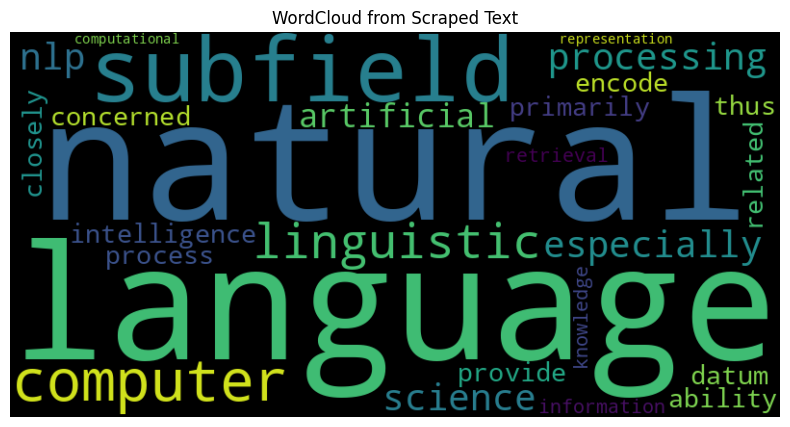

In [5]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Join the cleaned tokens into a single string
joined_text = " ".join(clean_tokens)

# Generate word cloud
wordcloud = WordCloud(width=800, height=400).generate(joined_text)

# Plot it
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud from Scraped Text")
plt.show()

Practical Example- Web Scraping and Sentiment Analysis on News Articles
===

In [2]:
"""
News Sentiment Mini-Pipeline (Google News RSS + NLTK VADER)
-----------------------------------------------------------
- Input: a list of keywords (strings).
- For each keyword, fetch the first N news items from Google News RSS.
- Score sentiment using NLTK's VADER (title + summary).
- Output: (1) DataFrame with per-article scores, (2) DataFrame with per-keyword summary.

Good for teaching:
- No API keys, minimal setup.
- Transparent lexicon-based sentiment (VADER).
- Easy to extend (CSV export, plots, etc.).
"""

from typing import List, Dict, Any
import urllib.parse
import feedparser
import pandas as pd
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer


# ----------------------------- NLTK setup ------------------------------------
def ensure_vader() -> None:
    """
    Ensure the VADER lexicon is available. Download once if missing.
    """
    try:
        nltk.data.find("sentiment/vader_lexicon.zip")
    except LookupError:
        nltk.download("vader_lexicon")


# ------------------------- Google News RSS helpers ---------------------------
def google_news_rss(query: str, hl: str = "en-US", gl: str = "US", ceid: str = "US:en") -> str:
    """
    Build a Google News RSS URL for a given query.

    Parameters:
        query: search terms (e.g., "bitcoin" or "artificial intelligence").
        hl: UI language (e.g., "en-US").
        gl: geolocation (country code, e.g., "US").
        ceid: country:language code used by Google News (e.g., "US:en").
    """
    base = "https://news.google.com/rss/search"
    q = urllib.parse.quote_plus(query)
    return f"{base}?q={q}&hl={hl}&gl={gl}&ceid={ceid}"


def fetch_news_items(query: str, limit: int = 5, hl: str = "en-US", gl: str = "US", ceid: str = "US:en") -> List[Dict[str, Any]]:
    """
    Fetch up to `limit` items from Google News RSS for the given query.
    Returns a list of dicts with title, link, published, summary.
    """
    feed_url = google_news_rss(query, hl=hl, gl=gl, ceid=ceid)
    parsed = feedparser.parse(feed_url)

    items: List[Dict[str, Any]] = []
    for entry in parsed.entries[:limit]:
        items.append({
            "title": entry.get("title", "").strip(),
            "link": entry.get("link", "").strip(),
            "published": entry.get("published", ""),
            "summary": entry.get("summary", "").strip(),
        })
    return items


# --------------------------- Sentiment utilities -----------------------------
def label_from_compound(c: float) -> str:
    """
    Map VADER compound score to a discrete label.
    VADER guideline: >= 0.05 positive, <= -0.05 negative, otherwise neutral.
    """
    if c >= 0.05:
        return "positive"
    elif c <= -0.05:
        return "negative"
    return "neutral"


# ------------------------------- Main pipeline -------------------------------
def analyze_news_sentiment(
    keywords: List[str],
    per_keyword: int = 5,
    hl: str = "en-US",
    gl: str = "US",
    ceid: str = "US:en",
):
    """
    For each keyword:
      - Fetch the first `per_keyword` news items from Google News RSS.
      - Compute sentiment on (title + summary) using VADER.
    Returns:
      df_news: article-level DataFrame (one row per article).
      df_summary: keyword-level summary (mean compound, class rates, count).
    """
    ensure_vader()
    sia = SentimentIntensityAnalyzer()

    rows = []
    for kw in keywords:
        items = fetch_news_items(kw, limit=per_keyword, hl=hl, gl=gl, ceid=ceid)
        for it in items:
            text = f"{it['title']} {it['summary']}".strip()
            scores = sia.polarity_scores(text)
            rows.append({
                "keyword": kw,
                "title": it["title"],
                "link": it["link"],
                "published": it["published"],
                "neg": scores["neg"],
                "neu": scores["neu"],
                "pos": scores["pos"],
                "compound": scores["compound"],
                "label": label_from_compound(scores["compound"]),
            })

    df_news = pd.DataFrame(rows)

    # If no articles were found for all keywords, return empty frames
    if df_news.empty:
        df_summary = pd.DataFrame(columns=["keyword", "mean_compound", "pos_rate", "neg_rate", "neu_rate", "n_articles", "label"])
        return df_news, df_summary

    # Aggregate by keyword
    df_summary = (
        df_news.groupby("keyword")
               .agg(mean_compound=("compound", "mean"),
                    pos_rate=("pos", "mean"),
                    neg_rate=("neg", "mean"),
                    neu_rate=("neu", "mean"),
                    n_articles=("compound", "count"))
               .reset_index()
    )
    df_summary["label"] = df_summary["mean_compound"].apply(label_from_compound)

    return df_news, df_summary


# --------------------------------- Demo run ----------------------------------
if __name__ == "__main__":
    # Feel free to edit keywords and per_keyword
    keywords = ["bitcoin", "artificial intelligence", "Mexico inflation"]
    df_news, df_summary = analyze_news_sentiment(keywords, per_keyword=3)

    # Pretty printing
    pd.set_option("display.max_colwidth", 120)

    print("\n=== News (article-level) ===")
    print(df_news)

    print("\n=== Summary (per keyword) ===")
    print(df_summary)

    # Optional: export
    # df_news.to_csv("news_sentiment_articles.csv", index=False)
    # df_summary.to_csv("news_sentiment_summary.csv", index=False)



=== News (article-level) ===
                   keyword  \
0                  bitcoin   
1                  bitcoin   
2                  bitcoin   
3  artificial intelligence   
4  artificial intelligence   
5  artificial intelligence   
6         Mexico inflation   
7         Mexico inflation   
8         Mexico inflation   

                                                                                                                   title  \
0                                                                Ether, the number two crypto, closes on bitcoin - Axios   
1                                         Bitcoin Price, XRP Drop. Why CPI Inflation Report Could Hit Crypto. - Barron's   
2                                           The Shrinking Bitcoin Dominance Story No One's Talking About - Yahoo Finance   
3  Which Artificial Intelligence (AI) Stock Is More Likely to Make You a Millionaire: Figma or Palantir? - Yahoo Finance   
4                                                